### Entrenamiento de DCGAN para proyecto 2.

Se utilizará la GAN llamada DCGAN, es una red neuronal convolucional. La arquitectura es la siguiente:

Generador:

Capa de entrada: Es una capa de entrada que toma una distribución de ruido aleatorio como entrada. Esta distribución de ruido suele seguir una distribución gaussiana o uniforme.

Capas ocultas convolucionales: Estas capas convolucionales toman la distribución de ruido y la transforman gradualmente en una imagen generada. Cada capa convolucional puede aumentar la dimensionalidad espacial de los datos mientras reduce la cantidad de canales.

Capa de salida: La capa de salida produce la imagen generada final. Generalmente, utiliza una función de activación como ReLU o una tangente hiperbólica para generar los píxeles de la imagen.

Discriminador:

Capa de entrada: Similar al generador, esta capa toma una imagen como entrada.

Capas convolucionales: El discriminador utiliza varias capas convolucionales para extraer características de la imagen de entrada.

Capa de salida: La capa de salida toma la representación de características extraída por las capas convolucionales y devuelve la probabilidad de que la imagen de entrada sea real o falsa.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install --upgrade tensorflow keras

In [ ]:
import keras
import tensorflow as tf

from keras import layers
from keras import ops
import matplotlib.pyplot as plt
import os
import gdown
from zipfile import ZipFile

El dataset utilizado fue obtenido en la página de [Kaggle](https://www.kaggle.com/datasets/birdy654/football-players-and-staff-faces?resource=download). Se trata de imágenes tanto de jugadores de fútbol como personas que conforman el staff. Las imágenes son de tamaño 128x128 y están en formato JPG. Este dataset cuenta con 8599 imágenes que serán utilizadas para entrenar la DCGAN.

In [ ]:
!unzip '/content/drive/MyDrive/football.zip' -d /content/

In [ ]:
dataset = keras.utils.image_dataset_from_directory(
    "/content/football", label_mode=None, image_size=(64, 64), batch_size=32
)
dataset = dataset.map(lambda x: x / 255.0)

Found 8599 files.


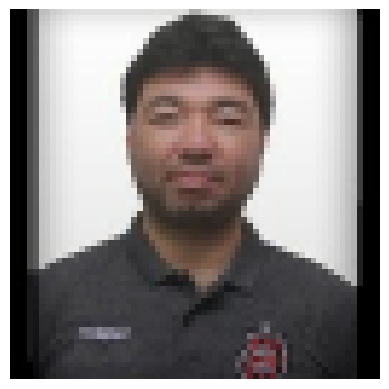

In [ ]:
for x in dataset:
    plt.axis("off")
    plt.imshow((x.numpy() * 255).astype("int32")[1])
    break

#### Discriminador

In [ ]:
discriminator = keras.Sequential(
    [
        keras.Input(shape=(64, 64, 3)),
        layers.Conv2D(64, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(negative_slope=0.2),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(negative_slope=0.2),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(negative_slope=0.2),
        layers.Flatten(),
        layers.Dropout(0.2),
        layers.Dense(1, activation="sigmoid"),
    ],
    name="discriminator",
)
discriminator.summary()


Model: "discriminator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 32, 32, 64)          │           3,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 16, 16, 128)         │         131,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 8, 8, 128)           │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_2 (LeakyReLU)            │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │           8,193 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 404,801 (1.54 MB)

 Trainable params: 404,801 (1.54 MB)

 Non-trainable params: 0 (0.00 B)

#### Generador

In [ ]:
latent_dim = 128

generator = keras.Sequential(
    [
        keras.Input(shape=(latent_dim,)),
        layers.Dense(8 * 8 * 128),
        layers.Reshape((8, 8, 128)),
        layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(negative_slope=0.2),
        layers.Conv2DTranspose(256, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(negative_slope=0.2),
        layers.Conv2DTranspose(512, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(negative_slope=0.2),
        layers.Conv2D(3, kernel_size=5, padding="same", activation="sigmoid"),
    ],
    name="generator",
)
generator.summary()

Model: "generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_1 (Dense)                      │ (None, 8192)                │       1,056,768 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose (Conv2DTranspose)   │ (None, 16, 16, 128)         │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_3 (LeakyReLU)            │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_1 (Conv2DTranspose) │ (None, 32, 32, 256)         │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_4 (LeakyReLU)            │ (None, 32, 32, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_2 (Conv2DTranspose) │ (None, 64, 64, 512)         │       2,097,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_5 (LeakyReLU)            │ (None, 64, 64, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 64, 64, 3)           │          38,403 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,979,651 (15.18 MB)

 Trainable params: 3,979,651 (15.18 MB)

 Non-trainable params: 0 (0.00 B)

##### Definición de la GAN, juntando el discriminador y el generador.

In [ ]:
class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.seed_generator = keras.random.SeedGenerator(1337)

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super().compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):
        # Sample random points in the latent space
        batch_size = ops.shape(real_images)[0]
        random_latent_vectors = keras.random.normal(
            shape=(batch_size, self.latent_dim), seed=self.seed_generator
        )

        # Decode them to fake images
        generated_images = self.generator(random_latent_vectors)

        # Combine them with real images
        combined_images = ops.concatenate([generated_images, real_images], axis=0)

        # Assemble labels discriminating real from fake images
        labels = ops.concatenate(
            [ops.ones((batch_size, 1)), ops.zeros((batch_size, 1))], axis=0
        )
        # Add random noise to the labels - important trick!
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        # Train the discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # Sample random points in the latent space
        random_latent_vectors = keras.random.normal(
            shape=(batch_size, self.latent_dim), seed=self.seed_generator
        )

        # Assemble labels that say "all real images"
        misleading_labels = ops.zeros((batch_size, 1))

        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Update metrics
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {
            "d_loss": self.d_loss_metric.result(),
            "g_loss": self.g_loss_metric.result(),
        }

In [ ]:
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=3, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim
        self.seed_generator = keras.random.SeedGenerator(42)

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = keras.random.normal(
            shape=(self.num_img, self.latent_dim), seed=self.seed_generator
        )
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            img = keras.utils.array_to_img(generated_images[i])
            img.save("generated_img_%03d_%d.png" % (epoch, i))

##### Entrenamiento de la GAN con el dataset personalizado

In [ ]:
epochs = 50

gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss_fn=keras.losses.BinaryCrossentropy(),
)

gan.fit(
    dataset, epochs=epochs, callbacks=[GANMonitor(num_img=10, latent_dim=latent_dim)]
)

Epoch 1/50
269/269 ━━━━━━━━━━━━━━━━━━━━ 111s 323ms/step - d_loss: 0.2325 - g_loss: 6.4681
Epoch 2/50
269/269 ━━━━━━━━━━━━━━━━━━━━ 71s 263ms/step - d_loss: 0.2073 - g_loss: 8.2717
Epoch 3/50
269/269 ━━━━━━━━━━━━━━━━━━━━ 83s 268ms/step - d_loss: 0.0953 - g_loss: 13.4840
Epoch 4/50
269/269 ━━━━━━━━━━━━━━━━━━━━ 83s 271ms/step - d_loss: 0.5094 - g_loss: 2.4636
Epoch 5/50
269/269 ━━━━━━━━━━━━━━━━━━━━ 73s 271ms/step - d_loss: 0.3381 - g_loss: 2.1143
Epoch 6/50
269/269 ━━━━━━━━━━━━━━━━━━━━ 82s 272ms/step - d_loss: 0.5671 - g_loss: 1.5214
Epoch 7/50
269/269 ━━━━━━━━━━━━━━━━━━━━ 82s 273ms/step - d_loss: 0.6264 - g_loss: 1.2138
Epoch 8/50
269/269 ━━━━━━━━━━━━━━━━━━━━ 73s 271ms/step - d_loss: 0.4386 - g_loss: 1.3631
Epoch 9/50
269/269 ━━━━━━━━━━━━━━━━━━━━ 73s 271ms/step - d_loss: 0.6789 - g_loss: 1.2438
Epoch 10/50
269/269 ━━━━━━━━━━━━━━━━━━━━ 73s 272ms/step - d_loss: 0.6162 - g_loss: 1.0661
Epoch 11/50
269/269 ━━━━━━━━━━━━━━━━━━━━ 73s 271ms/step - d_loss: 0.5815 - g_loss: 1.0307
Epoch 12/50
269/2

### Veamos las imágenes generadas por la gan con 50 epocas.

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


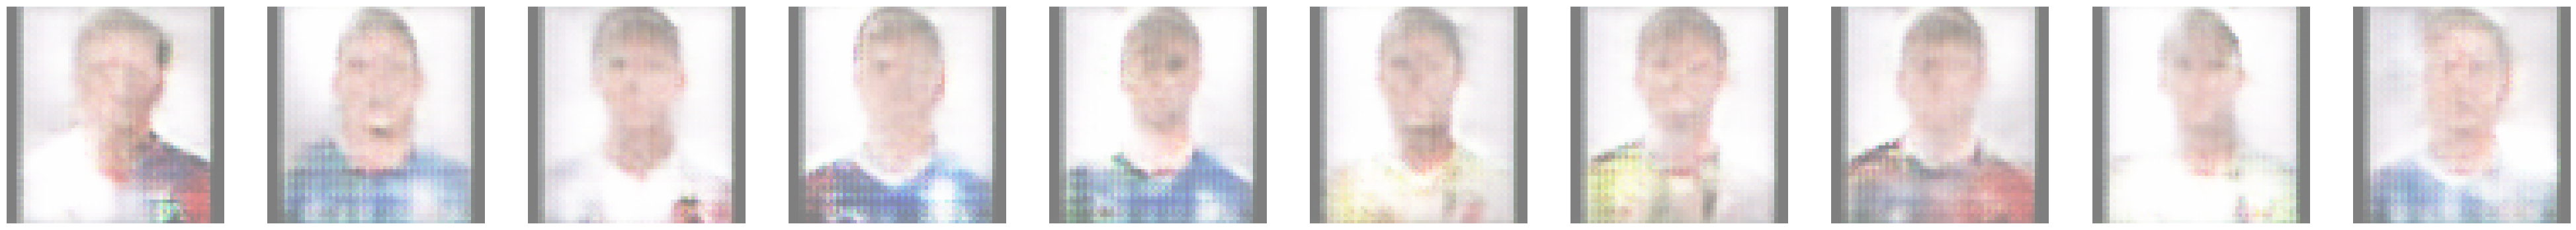

In [ ]:
import matplotlib.pyplot as plt

num_images_to_generate = 10
latent_dim = 128

random_latent_vectors = tf.random.normal(shape=(num_images_to_generate, latent_dim))

generated_images = generator.predict(random_latent_vectors)

# Muestra las imágenes generadas
plt.figure(figsize=(50, 50))
for i in range(num_images_to_generate):
    plt.subplot(1, num_images_to_generate, i + 1)
    plt.imshow(generated_images[i] * 0.5 + 0.5)  # Escala las imágenes al rango [0, 1]
    plt.axis("off")
plt.show()


### Conclusiones
Como se puede observar, los resultados de la GAN no son perfectos, esto puede ser debido a que el número de épocas fue bajo. Al aumentar el número de épocas se pueden mejorar los resultados del generador. Sin embargo, la pérdida del generador fue alta, esto también podría mejorar con un mayor número de épocas. La pérdida del discriminador fue mejor, con una del casi 0.5, lo cuál indica que podría mejorar igualmente con más épocas.